# Exploratory Data Analysis (EDA) of Colorectal Cancer Bulk RNA-seq Atlas

## Introduction

This notebook performs an initial exploration of a colorectal cancer (CRC) bulk RNA-seq dataset that has been batch-corrected using `pycombat-seq`. 

The goals are to:
- Summarize the clinical and molecular cohort composition.
- Visualize distributions of key variables.
- Perform dimensionality reduction (PCA, UMAP) to reveal biological patterns or clusters.
- Generate hypotheses for downstream analyses based on observed data structure.

## Dataset

- **Gene expression matrix**: normalized and batch-corrected bulk RNA-seq data.
- **Clinical metadata**: patient and sample information including biopsy site, sample type, and clinical variables.

## Sample Sources

The samples used in this analysis are derived from three primary public resources:

- **GEO (Gene Expression Omnibus):** Individual experimental samples identified by GSM accessions.
- **GTEx (Genotype-Tissue Expression Project):** Healthy human tissue samples with IDs starting with "GTEX-".
- **TCGA (The Cancer Genome Atlas):** Cancer patient tumor and normal samples following the TCGA barcode format.

These diverse datasets provide a comprehensive overview of gene expression across healthy and diseased states.

## Tools & Libraries

We use Python libraries such as `pandas`, `matplotlib`, `seaborn`, and `plotly` for data processing and visualization.




## 🎯 Planned Analysis Direction

I will focus on the following two analyses, **a list of other anlysis with their techniques and goals is provided at the end**:

1. **Global Expression Profiling**   relying only on expression matrix, age and sex (only hsared features between healthy and cancer).
2. **Survival Analysis (OS)** integrating cancer information with expression matrix


---

### ✅ Justification

**Why is this analysis valuable in the context of CRC?**  
- **Global profiling** captures tumor-specific transcriptomic changes, supporting the identification of disrupted pathways and molecular patterns distinguishing CRC from normal tissue.
- **Survival analysis**, informed by both gene expression and cancer-specific clinical features (e.g., `st, age`, `msi_status`, `therapy_type`), helps uncover molecular predictors of prognosis in a clinically meaningful way.

**What insight do you aim to generate?**  
- Define gene and pathway signatures differentiating healthy vs cancer tissue.
- Identify gene-level and clinical predictors associated with overall and progression-free survival in CRC.

---

### ⚠️ Limitations & Handling Missing Data

- **Incomplete annotation** affects many cancer-related features (e.g., `msi_status`, `stage`, `therapy_response`).  
- To address this:
  - I will  drop columns with very high percentage NAs, impute the rest (beased on frequency/mean, or nearest neighbor depending on the variable).
  - Since this will only be done on the subset of data which has survival information, generalizing these exact methods need further vertification.

---

## 1. Cohort Overview & Data Integrity

In this section, we perform an initial summary of the colorectal cancer (CRC) cohort and assess the integrity of the data. This includes:

- Summarizing the number of samples and patients
- Characterizing clinical variables such as biopsy site, sample type, age, and stage
- Checking for missing values and data completeness
- Verifying data types and value distributions

Understanding the structure and quality of the data is critical before proceeding to downstream analyses.


In [146]:
# importing libraries
import pandas as pd
import conorm
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
import scanpy as sc
import anndata
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, accuracy_score

# load the data
metadata_df = pd.read_csv('../data/CRC_atlas_clinical_data.csv', index_col=0)
expression_df = pd.read_csv('../data/CRC_atlas_gene_expression_data.csv', index_col=0)

### Dataset Overview and Metadata Summary

The dataset contains **2,770 samples** with accompanying clinical and biological metadata consisting of **34 columns**. These columns capture a broad spectrum of information relevant to both healthy (control) and cancerous colorectal tissue samples.

Key characteristics of the metadata include:

- **General patient information:**  
  Variables such as `age` (1,776 non-missing values) and `gender` (1,733 non-missing) are available for a majority of samples, providing essential demographic context.

- **Biopsy details:**  
  The biopsy site is recorded for all samples (`biopsy_site`), while other related variables such as `biopsy_subsite` (1,296 non-missing) and `biopsy_timepoint` (1,425 non-missing) provide more granular temporal and spatial context.

- **Cancer-specific features:**  
  Several columns reflect tumor-specific characteristics, though many contain substantial missing data, likely due to sample heterogeneity or incomplete annotation. For example:  
  - Mutation status for key oncogenes and tumor suppressors like `braf_mutation` (619 non-null), `kras_mutation` (525), `egfr_mutated` (515), and `tp53_mutation` (515).  
  - Molecular subtyping information, such as `cms` (consensus molecular subtype; 581 non-null), `molecular_type` (236 non-null), and `msi_status` (microsatellite instability; 785 non-null).  
  - Tumor staging and grading data is sparse, with only 835 and 79 samples annotated for `stage` and `grade`, respectively.

- **Treatment and outcome variables:**  
  Several clinical outcome and treatment response variables exist but with limited coverage, for example:  
  - Overall survival status (`os_status`, 631 non-null) and time (`os_time`, 630 non-null).  
  - Progression-free survival status (`pfs_status`, 230 non-null) and time (`pfs_time`, 85 non-null).  
  - Therapy response (`therapy_response`, 593 non-null) and therapy type (`therapy_type`, 961 non-null).

- **Sample type and tumor characterization:**  
  Sample types are fully annotated (`sample_type`), distinguishing between healthy and cancerous tissues, and tumor classification is available for most cancer samples (`tumor_type`, 1,971 non-null).

### Missing Data Considerations

Many clinically important features have high rates of missingness, which will need to be addressed during downstream analyses, either by filtering, imputation, or careful interpretation of results to avoid bias.




In [147]:
# Display basic info
print("Clinical Data Overview:")
metadata_df.columns = metadata_df.columns.str.replace(' ', '_').str.lower()
display(metadata_df.shape)
display(metadata_df.info())
display(metadata_df.head())

Clinical Data Overview:


(2770, 34)

<class 'pandas.core.frame.DataFrame'>
Index: 2770 entries, GSM1133352 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1776 non-null   float64
 1   age_category          1442 non-null   object 
 2   biopsy_subsite        1296 non-null   object 
 3   braf_mutation         619 non-null    object 
 4   biopsy_site           2770 non-null   object 
 5   biopsy_timepoint      1425 non-null   object 
 6   cms                   581 non-null    object 
 7   cancer_type           631 non-null    object 
 8   distal_vs_proximal    1662 non-null   object 
 9   donor_type            2770 non-null   object 
 10  egfr_mutated          515 non-null    object 
 11  grade                 79 non-null     object 
 12  her2_mutation         0 non-null      float64
 13  histological_subtype  1966 non-null   object 
 14  histological_type     1966 non-null   object

None

,age,age_category,biopsy_subsite,braf_mutation,biopsy_site,biopsy_timepoint,cms,cancer_type,distal_vs_proximal,donor_type,...,pfs_time,sample_type,gender,stage,tmb,tmb_group,tp53_mutation,therapy_response,therapy_type,tumor_type
GSM1133352,80.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Healthy sample,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM1133353,80.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM1133355,76.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Healthy sample,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM2042099,NaN,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM2042100,NaN,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor


### Initial Data Cleaning

To prepare the dataset for downstream analysis, the following initial cleaning steps were performed:

- **Removed columns with only a single unique value:**  
  Columns that do not vary across samples (i.e., contain the same value for all samples) provide no informative signal and were excluded. This resulted in the removal of 5 such columns.

- **Removed columns with redundant or duplicated information:**  
  Certain columns contained overlapping or duplicated data, such as `sample_type` and `donor_type`. To avoid redundancy and potential confusion, one of each redundant pair was removed.

- **Filtered samples with inconsistent or contradictory metadata:**  
  A small number of samples exhibiting conflicting information across related columns (e.g., contradictory sample type and donor type annotations) were identified and excluded to ensure data integrity.

These cleaning steps ensure a more reliable and interpretable dataset for further analysis.


In [148]:
# Count unique values per column
unique_counts = metadata_df.nunique()

# Identify columns with only one unique value
cols_to_drop = unique_counts[unique_counts <= 1].index.tolist()

print("Dropped columns with a single unique value:")
for col in cols_to_drop:
    print(f"- {col}")

# Drop those columns
metadata_df = metadata_df.loc[:, unique_counts > 1]

print(f"Dropped {len(cols_to_drop)} columns in total.")


Dropped columns with a single unique value:
- age_category
- cancer_type
- her2_mutation
- line_of_treatment
- tumor_type
Dropped 5 columns in total.


In [149]:
# Condition 1: donor_type == 'Tumor' → sample_type == 'Primary cancer'
cond1 = (metadata_df['donor_type'] == 'Tumor') & (metadata_df['sample_type'] != 'Primary cancer')
num_violations1 = cond1.sum()

print(f"Number of samples where donor_type is 'Tumor' but sample_type is NOT 'Primary cancer': {num_violations1}")


# Condition 2: donor_type == 'Normal' → sample_type == 'Healthy sample'
cond2 = (metadata_df['donor_type'] == 'Normal') & (metadata_df['sample_type'] != 'Healthy sample')
num_violations2 = cond2.sum()

print(f"\nNumber of samples where donor_type is 'Normal' but sample_type is NOT 'Healthy sample': {num_violations2}")

# filtering samples with contradicting information
metadata_df= metadata_df.loc[~ cond1]
expression_df = expression_df.loc[:, ~cond1]

metadata_df= metadata_df.loc[~ cond2]
expression_df = expression_df.loc[:, ~cond2]

metadata_df = metadata_df.drop(['donor_type'], axis=1)

Number of samples where donor_type is 'Tumor' but sample_type is NOT 'Primary cancer': 2

Number of samples where donor_type is 'Normal' but sample_type is NOT 'Healthy sample': 0


### Sample Composition and Source Distribution

To understand the composition of our cohort, we began by visualizing the distribution of sample types and their sources.

- **Sample Type Distribution:**  
  A bar plot of sample types shows a clear class imbalance: approximately **30% of the samples are healthy**, while the remaining **70% are cancerous**. This imbalance is important to note, as it may influence downstream analyses, particularly classification tasks or comparisons between conditions.

- **Data Source Distribution:**  
  The dataset aggregates samples from **three major public sources**:
  - **GTEx:** Provides only **healthy tissue** samples.
  - **TCGA:** Contributes **cancerous** colorectal tissue samples.
  - **GEO:** A mixed dataset, but predominantly composed of **cancerous** samples, and also the **largest contributor** in terms of sample count.

These initial visualizations provide important context for the analysis and highlight both the **heterogeneity of sources** and the **imbalance in class representation**, which should be considered in subsequent steps.


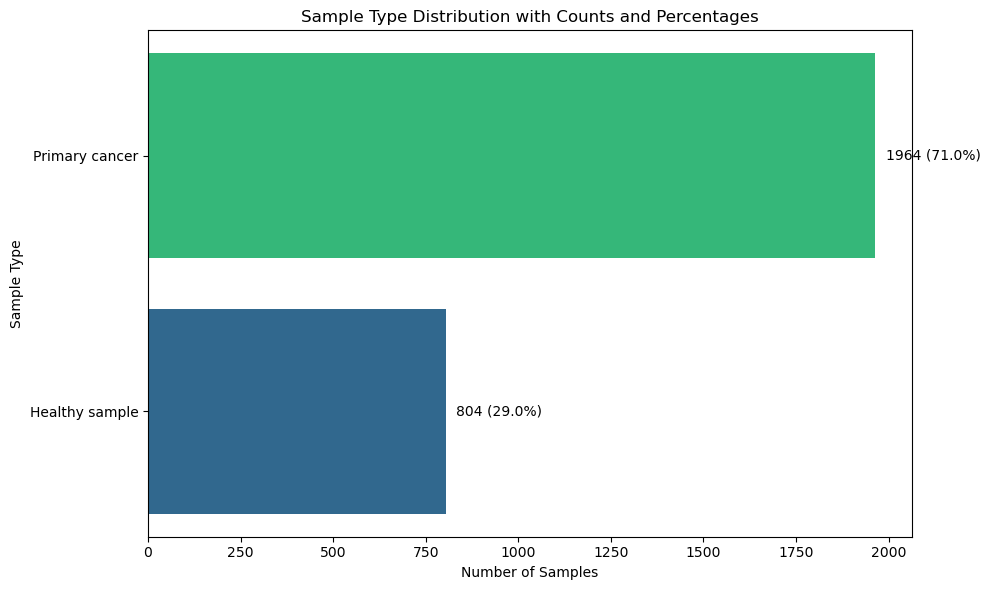

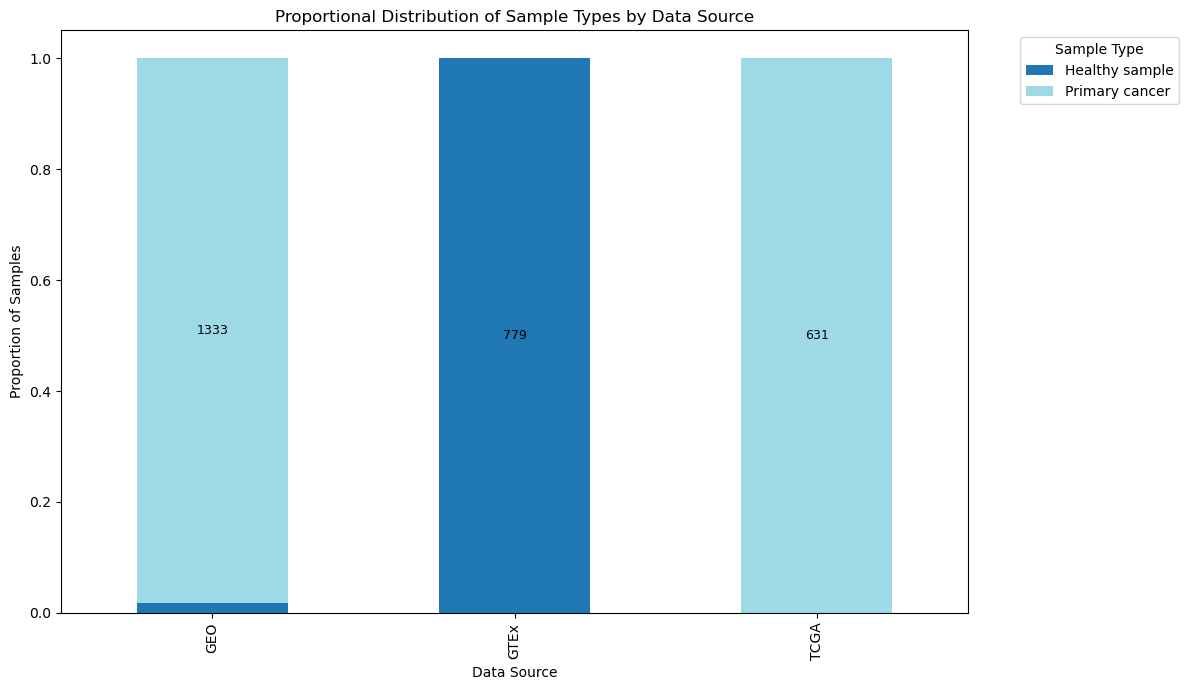

In [150]:
# Add a column indicating data source (GEO, GTEx, or TCGA)
# This function checks the prefix of the sample ID to assign the correct source
def get_data_source(sample_id):
    if sample_id.startswith('GSM'):
        return 'GEO'
    elif sample_id.startswith('GTEX'):
        return 'GTEx'
    elif sample_id.startswith('TCGA'):
        return 'TCGA'

# Apply the function to the sample IDs (which are used as index)
metadata_df['data_source'] = metadata_df.index.map(get_data_source)

# Horizontal bar chart of sample type distribution

# Count how many samples of each type (e.g., healthy, cancerous)
sample_type_counts = metadata_df['sample_type'].value_counts().sort_values()

# Total number of samples (used for calculating percentages)
total_samples = len(metadata_df)

# Create figure
plt.figure(figsize=(10, 6))

# Plot horizontal bar chart
bars = plt.barh(sample_type_counts.index,
                sample_type_counts.values,
                color=sns.color_palette("viridis", len(sample_type_counts)))

# Annotate each bar with the absolute count and percentage
for bar in bars:
    width = bar.get_width()
    plt.text(width + total_samples * 0.01,              # small offset to the right of the bar
             bar.get_y() + bar.get_height() / 2,        # vertical center of the bar
             f'{width} ({width / total_samples:.1%})',  # format: "count (percent%)"
             va='center', fontsize=10)

# Add plot labels and formatting
plt.title('Sample Type Distribution with Counts and Percentages')
plt.xlabel('Number of Samples')
plt.ylabel('Sample Type')
plt.tight_layout()
plt.show()

# Stacked bar chart of sample type proportions by data source

# Create crosstab of data_source vs. sample_type
# `ct` will contain proportions (normalized by row)
ct = pd.crosstab(metadata_df['data_source'], metadata_df['sample_type'], normalize='index')

# `ct_counts` will contain raw counts
ct_counts = pd.crosstab(metadata_df['data_source'], metadata_df['sample_type'])

# Plot the normalized stacked bar chart
ct.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 7))
plt.title('Proportional Distribution of Sample Types by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Proportion of Samples')

# Annotate bars with raw counts for each segment
for i, data_source in enumerate(ct.index):  # Loop over data sources (bar positions)
    cum_width = 0
    for sample_type in ct.columns:          # Loop over sample types (bar segments)
        val = ct.loc[data_source, sample_type]      # proportion
        count = ct_counts.loc[data_source, sample_type]  # raw count
        if val > 0.05:  # Only annotate if segment is >5% of the bar
            plt.text(i,
                     cum_width + val / 2,
                     f'{count}',
                     ha='center', va='center', fontsize=9, color='black')
        cum_width += val  # Update cumulative height for stacking

# Move legend outside the plot for clarity
plt.legend(title='Sample Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Biopsy Site Composition

The majority of samples in the dataset originate from the **colon**, which is expected given the colorectal cancer (CRC) focus of the study.

- **Healthy samples** are exclusively from the **colon**, with only a small number labeled as coming from the **colorectum**.
- **Tumor samples**, on the other hand, are more diverse in their biopsy site annotations, including **colon**, **colorectum**, and other redions like rectum and rectosigmoid function.

This distribution highlights a potential **sampling bias**, where healthy tissues are underrepresented in non-colon colorectal regions. This should be taken into account during comparative or site-specific analyses, especially when controlling for tissue location.


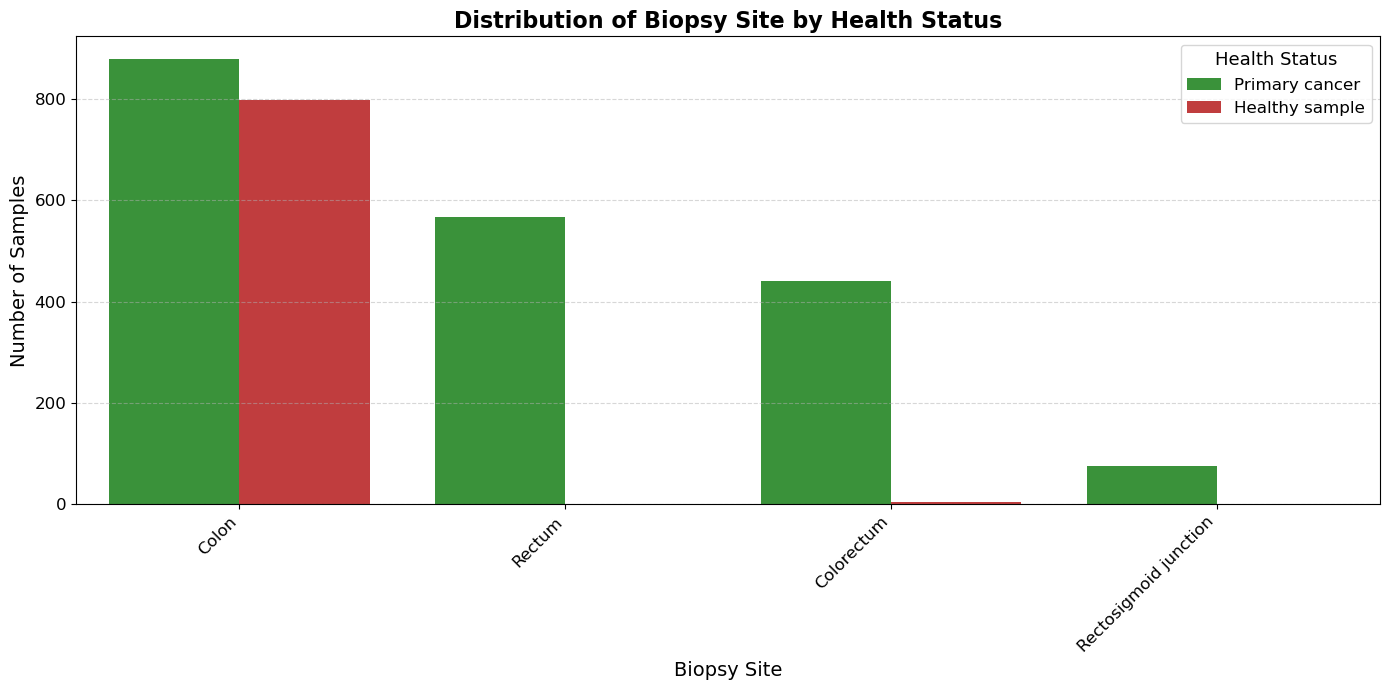

In [151]:
# Create a figure with a wide aspect ratio for better readability
plt.figure(figsize=(14, 7))

# Create a grouped bar chart (countplot) of sample counts per biopsy site
# The bars are colored by sample_type (e.g., healthy vs cancerous)
# Custom colors: green for healthy, red for cancerous
sns.countplot(
    data=metadata_df,
    x='biopsy_site',
    hue='sample_type',
    palette=['#2ca02c', '#d62728']  # Green and red color palette
)

# Add a descriptive title and axis labels
plt.title('Distribution of Biopsy Site by Health Status', fontsize=16, weight='bold')
plt.xlabel('Biopsy Site', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Customize the legend
plt.legend(title='Health Status', title_fontsize='13', fontsize='12')

# Add horizontal grid lines to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.show()

### Age Distribution by Health Status

The **age** variable follows an approximately **normal distribution** overall, but with clear differences between healthy and cancerous samples:

- **Cancer samples** are centered around **older ages**, reflecting the typical onset age for colorectal cancer.
- **Healthy samples** tend to have a **younger distribution**, although all samples in the dataset are from **adults (18 years and older)**.

It's also important to note that approximately **35% of the samples are missing age information**. This level of missingness should be taken into account in downstream analyses, especially when age is considered a covariate. **Imputation** can be done using the mean of each group or nearest nieghbors based on expression matrix.

Due to the **systematic difference** in age distributions between healthy and cancerous groups, I will apply **group-specific scaling (standardization)** to the age variable. This helps to **reduce bias** and ensure that age effects are interpreted in the correct biological context.


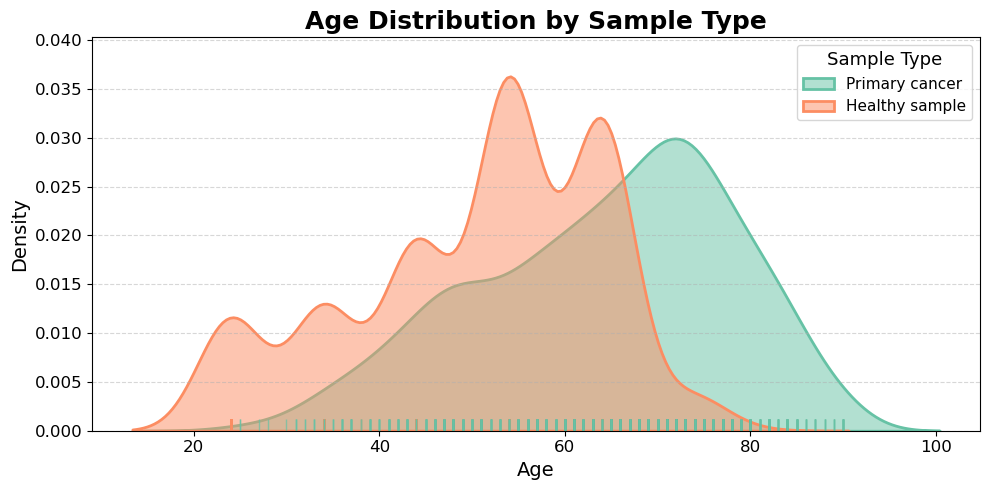

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out missing age or sample_type
age_sample = metadata_df[['age', 'sample_type']].dropna()

plt.figure(figsize=(10, 5))

# Define colors with more contrast and saturation
palette = sns.color_palette('Set2', len(age_sample['sample_type'].unique()))

# Plot KDE with filled areas and a slight transparency
for i, stype in enumerate(age_sample['sample_type'].unique()):
    subset = age_sample[age_sample['sample_type'] == stype]['age']
    sns.kdeplot(subset, fill=True, alpha=0.5, linewidth=2, label=stype, color=palette[i])

# Add rug plot for individual data points
sns.rugplot(data=age_sample, x='age', hue='sample_type', palette=palette, height=0.03, alpha=0.7)

# Style enhancements
plt.title('Age Distribution by Sample Type', fontsize=18, weight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Sample Type', title_fontsize='13', fontsize='11', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



In [153]:
num_under_18 = (metadata_df['age'] < 18).sum()
total_samples = len(metadata_df)
print(f"Samples with Age < 18: {num_under_18} / {total_samples} ({num_under_18/total_samples:.1%})")

# Check how many missing in Age category
num_missing = metadata_df['age'].isna().sum()
total = len(metadata_df)
print(f"Missing values in 'Age': {num_missing} / {total} ({num_missing/total:.1%})")

Samples with Age < 18: 0 / 2768 (0.0%)
Missing values in 'Age': 994 / 2768 (35.9%)


In [154]:
scaler = StandardScaler()
# Optionally assign back to original df (if you want to keep in same variable)
metadata_df['age_scaled'] = scaler.fit_transform(metadata_df[['age']])

### Gender Distribution by Health Status

The **gender** distribution is relatively **balanced between healthy and cancerous groups**, showing no major skew that would suggest sampling bias across health statuses.

- In both groups, **females are slightly underrepresented** compared to males.
- The proportions are similar between healthy and cancer samples, which supports the use of gender as a covariate if needed.

However, it's important to highlight that **gender data is missing for approximately 37% of the samples**. This significant missingness should be considered during analyses that include gender, and may require **imputation** (neares neighbor based on expression) or exclusion strategies depending on the context.


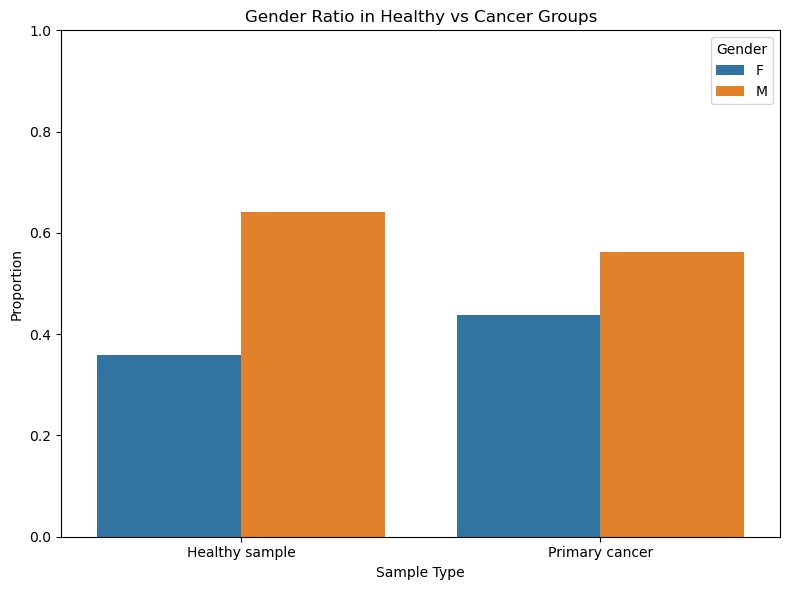

In [155]:
# Calculate counts
counts = metadata_df.groupby(['sample_type', 'gender']).size().reset_index(name='count')

# Calculate total counts per sample_type for ratio
totals = counts.groupby('sample_type')['count'].transform('sum')
counts['ratio'] = counts['count'] / totals

# Plot with ratios
plt.figure(figsize=(8,6))
sns.barplot(data=counts, x='sample_type', y='ratio', hue='gender')

plt.title('Gender Ratio in Healthy vs Cancer Groups')
plt.ylabel('Proportion')
plt.xlabel('Sample Type')
plt.ylim(0, 1)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [156]:
# Check how many missing in Age category
num_missing = metadata_df['gender'].isna().sum()
total = len(metadata_df)
print(f"Missing values in 'Sex': {num_missing} / {total} ({num_missing/total:.1%})")

Missing values in 'Sex': 1037 / 2768 (37.5%)


#### 🔬 Normalization of Batch-Corrected Bulk RNA-seq Data

After batch correction using **ComBat-Seq**, I applied the following normalization steps:

1. **TMM Normalization**  
   - Performed using **CoNorm**, which implements the **Trimmed Mean of M-values (TMM)** method.
   - This corrects for differences in library size and composition between samples.

2. **Log Transformation**  
   - Applied log2 transformation with a pseudocount
   - Reduces skewness and stabilizes variance across genes.
   - after log transofrmation, I remove the genes that are present in less than 20% of the samples

3. **Z-score Scaling**  
   - Standardized each gene (row-wise) to mean 0 and standard deviation 1
   - Useful for clustering, PCA, and other machine learning tasks.



In [157]:
# TMM normalization
expression_tmm = conorm.tmm(expression_df)
# Log scaling
log_tmm = np.log2(expression_tmm + 1)

# Keep genes expressed in at least 20% of the samples
min_samples = log_tmm.shape[1]//5
filtered_expr = log_tmm.loc[(log_tmm > 1).sum(axis=1) > min_samples,:]
expression_df.loc[filtered_expr.index]
# z-score calculation
scaler = StandardScaler()
scaled_log_tmm = pd.DataFrame(scaler.fit_transform(filtered_expr.T),
                              index=filtered_expr.columns,
                              columns=filtered_expr.index)
# examining final normalized file
scaled_log_tmm.shape

(2768, 19832)

#### Highly variable genes and visualozation


1. **Highly variable genes**  
   - Using scanpy, I select the 200 most highly vatiable genes

2. **Visulaization**  
   - I visualize PCA, T-SNE, and UMAP. Healthy and cancerous samples are well seperated in all, with few exceptions.

c:\Users\randf\.conda\envs\crc_env\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


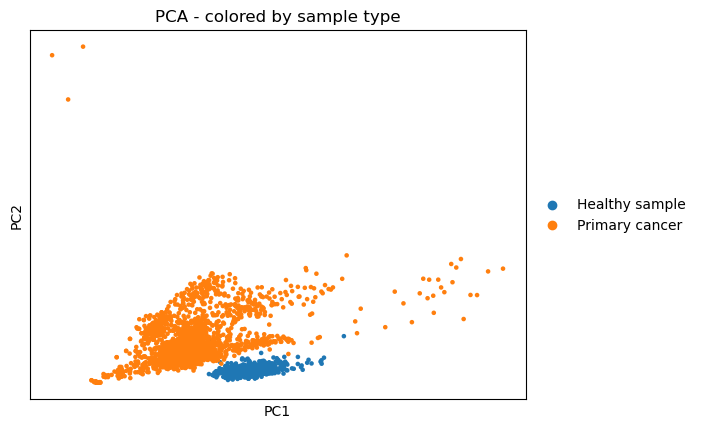

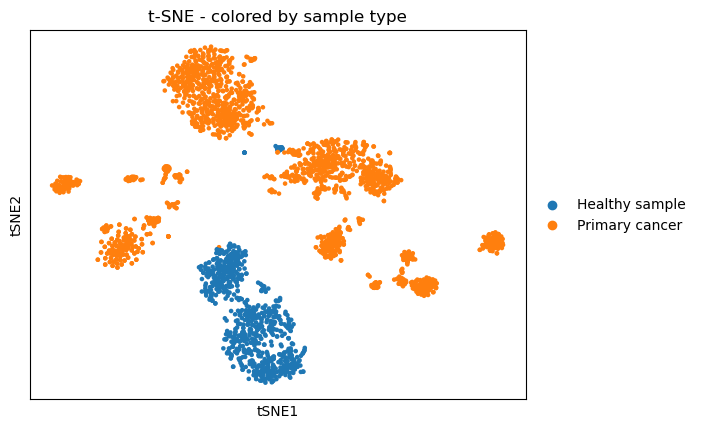

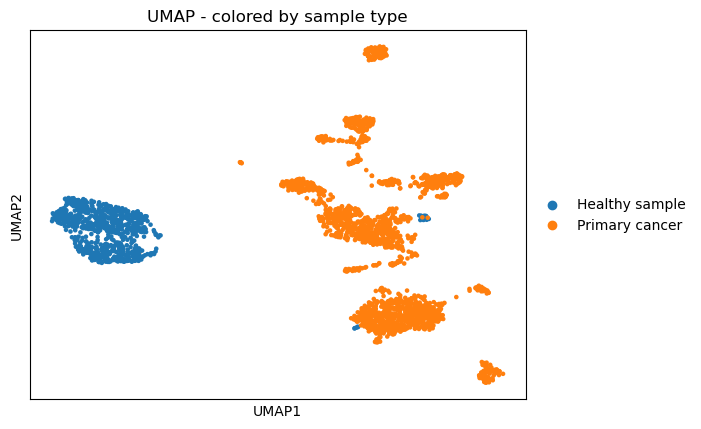

In [158]:
filtered_expr = filtered_expr.transpose()
adata = anndata.AnnData(filtered_expr)

# chack the match in index
metadata_df = metadata_df.loc[adata.obs_names]

# Add all columns from metadata_df to adata.obs
for col in metadata_df.columns:
    adata.obs[col] = metadata_df[col]

# Select Highly Variable Genes 
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)
adata = adata[:, adata.var['highly_variable']]

# Scale data (z-score genes)
sc.pp.scale(adata)

# PCA
sc.tl.pca(adata)

# t-SNE
sc.tl.tsne(adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)

# Plot PCA colored by sample_type
sc.pl.pca(adata, color='sample_type', title='PCA - colored by sample type')

# Plot t-SNE colored by sample_type
sc.pl.tsne(adata, color='sample_type', title='t-SNE - colored by sample type')

# Plot UMAP colored by sample_type
sc.pl.umap(adata, color='sample_type', title='UMAP - colored by sample type')

## 🧩 Imputation Strategy Using Expression Profiles

To address missing values in key clinical features (Age and Sex), I will apply **K-nearest neighbors (KNN) imputation** based on **expression similarity** within biologically consistent groups.

---

### 🧬 Expression-Based KNN Imputation Plan

**Step 1: Split by biological group**  
- Perform imputation **separately** for:
  - `Healthy` samples
  - `Cancer` samples

> This avoids confounding due to large expression shifts between normal and tumor tissue.


**Step 2: Use Standardize expression**  
- Normalize and scale expression values (e.g., Z-score per gene) prior to distance calculation.

**Step 3: Choose best `k` (number of neighbors)**  
- Use cross-validation (e.g., mask known values) to evaluate imputation accuracy for different `k` values (e.g., `k = 3, 5, 7, 10`).  
- Optimize based on lowest error or highest agreement with known labels.

**Step 4: Impute missing values**  
- For categorical features (`Sex`): use majority vote among k neighbors.  
- For continuous features (`age`): use average of neighbor values.



In [159]:
scaled_log_tmm_cancer = scaled_log_tmm.loc[:, scaled_log_tmm.columns.intersection(adata.var_names)]

# Parameters
target_vars = ['age', 'gender']
groups = metadata_df['sample_type'].unique()
k_values = [3, 5, 7, 10]


# Parameters
target_vars = ['age', 'gender', 'age_scaled']
groups = metadata_df['sample_type'].unique()
k_values = [3, 5, 7, 10]

# Encode gender to numeric
sex_map = {'M': 0, 'F': 1}
reverse_sex_map = {v: k for k, v in sex_map.items()}
metadata_df['gender_num'] = metadata_df['gender'].map(sex_map)

def evaluate_imputation(true_vals, imputed_vals, var):
    """Calculate error metric depending on variable type."""
    mask = ~true_vals.isna()
    if var == 'age':
        # RMSE on observed values
        return np.sqrt(mean_squared_error(true_vals[mask], imputed_vals[mask]))
    elif var == 'gender_num':
        # Accuracy on observed values (rounded imputed values)
        return 1 - accuracy_score(true_vals[mask], imputed_vals[mask].round().astype(int))
    else:
        return np.nan

for group in groups:
    print(f"\nProcessing group: {group}")
    mask = metadata_df['sample_type'] == group
    meta_sub = metadata_df.loc[mask, ['age', 'gender_num']].copy()
    
    merged_df = meta_sub.merge(scaled_log_tmm_cancer, left_index=True, right_index=True, how='left')
    impute_data = pd.concat([merged_df[['age', 'gender_num']], merged_df.drop(columns=['age', 'gender_num'])], axis=1)
    
    # Mask a random 10% of observed values in targets for error estimation
    impute_mask = impute_data[['age', 'gender_num']].notna()
    mask_fraction = 0.1
    random_state = 42
    np.random.seed(random_state)
    
    # Copy original target data for comparison
    true_targets = impute_data[['age', 'gender_num']].copy()
    impute_data_masked = impute_data.copy()
    
    for col in ['age', 'gender_num']:
        observed_indices = impute_mask[col][impute_mask[col]].index
        n_mask = int(len(observed_indices) * mask_fraction)
        mask_indices = np.random.choice(observed_indices, n_mask, replace=False)
        impute_data_masked.loc[mask_indices, col] = np.nan
    
    errors = []
    for k in k_values:
        imputer = KNNImputer(n_neighbors=k)
        imputed_array = imputer.fit_transform(impute_data_masked)
        imputed_df = pd.DataFrame(imputed_array, columns=impute_data.columns, index=impute_data.index)
        
        # Calculate error for each target variable
        age_error = evaluate_imputation(true_targets['age'], imputed_df['age'], 'age')
        gender_error = evaluate_imputation(true_targets['gender_num'], imputed_df['gender_num'], 'gender_num')
        
        # Weighted sum of errors (can adjust weights if needed)
        total_error = age_error + gender_error
        errors.append((k, total_error))
        print(f"k={k}: total error={total_error:.4f} (age RMSE={age_error:.4f}, gender err={gender_error:.4f})")
    
    # Choose best k
    best_k = min(errors, key=lambda x: x[1])[0]
    print(f"Selected k={best_k} for group {group}")
    
    # Impute full data with best k
    final_imputer = KNNImputer(n_neighbors=best_k)
    final_imputed_array = final_imputer.fit_transform(impute_data)
    final_imputed_df = pd.DataFrame(final_imputed_array, columns=impute_data.columns, index=impute_data.index)
    
    # Extract and update targets
    imputed_targets = final_imputed_df[['age', 'gender_num']]
    imputed_targets['gender_num'] = imputed_targets['gender_num'].round().astype(int)
    imputed_targets['gender'] = imputed_targets['gender_num'].map(reverse_sex_map)
    
    metadata_df.loc[mask, 'age'] = imputed_targets['age']
    metadata_df.loc[mask, 'gender'] = imputed_targets['gender']

print("\nImputation and k optimization completed.")
    


Processing group: Primary cancer
k=3: total error=5.3963 (age RMSE=5.3456, gender err=0.0507)
k=5: total error=4.9762 (age RMSE=4.9308, gender err=0.0454)
k=7: total error=4.8180 (age RMSE=4.7673, gender err=0.0507)
k=10: total error=4.7576 (age RMSE=4.7080, gender err=0.0496)
Selected k=10 for group Primary cancer


C:\Users\randf\AppData\Local\Temp\ipykernel_19728\2373266051.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_targets['gender_num'] = imputed_targets['gender_num'].round().astype(int)
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\2373266051.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_targets['gender'] = imputed_targets['gender_num'].map(reverse_sex_map)



Processing group: Healthy sample
k=3: total error=5.0327 (age RMSE=4.9830, gender err=0.0497)
k=5: total error=4.8193 (age RMSE=4.7772, gender err=0.0421)
k=7: total error=4.8050 (age RMSE=4.7654, gender err=0.0395)
k=10: total error=4.8366 (age RMSE=4.8047, gender err=0.0319)
Selected k=7 for group Healthy sample

Imputation and k optimization completed.


C:\Users\randf\AppData\Local\Temp\ipykernel_19728\2373266051.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_targets['gender_num'] = imputed_targets['gender_num'].round().astype(int)
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\2373266051.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_targets['gender'] = imputed_targets['gender_num'].map(reverse_sex_map)


In [162]:

# saving the files
# Convert highly variable gene matrix to DataFrame
hvg_matrix = pd.DataFrame(
    adata.X,
    index=adata.obs_names,
    columns=adata.var_names
)

# Save as CSV
hvg_matrix.to_csv("../data/cancer_healthy_hvg.csv")
metadata_df.to_csv('../data/metadata.csv')
scaled_log_tmm_cancer.to_csv('../data/final_expression_cancer_health.csv')
expression_df.to_csv('../data/filtered_raw_expression.csv')
scaled_log_tmm.to_csv('../data/scaled_log_tmm.csv')

fig, ax = plt.subplots()
sc.pl.pca(adata, color='sample_type', title='PCA - colored by sample type', ax=ax, show=False)
fig.savefig('../results/pca_sample_type.png')
plt.close(fig)

fig, ax = plt.subplots()
sc.pl.tsne(adata, color='sample_type', title='t-SNE - colored by sample type', ax=ax, show=False)
fig.savefig('../results/tsne_sample_type.png')
plt.close(fig)

fig, ax = plt.subplots()
sc.pl.umap(adata, color='sample_type', title='UMAP - colored by sample type', ax=ax, show=False)
fig.savefig('../results/umap_sample_type.png')
plt.close(fig)


# 🧬 Colorectal Cancer Cohort: RNA-Seq & Clinical Metadata Analysis Plan

This cohort includes bulk RNA expression data and rich clinical annotations for colorectal cancer (CRC) patients and healthy controls. Despite some missingness, the dataset offers significant potential for understanding CRC pathogenesis, heterogeneity, treatment response, and survival dynamics.

---

## 🔍 General Overview of the Dataset

| Variable Group              | Key Fields                                                                                                                                  | Notes                                                                                      |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| **Demographics**           | `age`, `gender`                                                                                                                             | High completeness, important for baseline adjustment and demographic stratification       |
| **Biopsy Information**     | `biopsy_site`, `biopsy_subsite`, `biopsy_timepoint`                                                                                        | Enables spatial/temporal context; useful for tracking progression                         |
| **Cancer-Specific Features** | `braf_mutation`, `kras_mutation`, `egfr_mutated`, `tp53_mutation`, `cms`, `molecular_type`, `msi_status`, `stage`, `grade`               | Moderate to high missingness; useful for deeper stratification and precision medicine     |
| **Treatment & Outcomes**   | `therapy_type`, `therapy_response`, `os_status`, `os_time`, `pfs_status`, `pfs_time`                                                       | Critical for predictive modeling; sample size may limit power in survival analyses        |
| **Sample Characterization** | `sample_type` (healthy vs cancer), `tumor_type`                                                                                            | Essential for comparative analysis between healthy and tumor tissue                       |

---

## 🧭 Downstream Analyses

The following analytical pipelines are proposed, each targeting a biological or clinical question relevant to CRC. Analyses are organized by scope.

---

### 1. **Healthy and cancer samples comparision** 

#### **A. Global Expression Profiling**
- **Question**: What are the overall transcriptomic differences between healthy and cancerous colorectal tissue?
- **Data Needed**: `sample_type`, RNA-seq expression matrix
- **Approach**:
  - Principal Component Analysis (PCA), t-SNE/UMAP
  - Differential expression analysis (DESeq2 (pydeseq2), edgeR)
  - Volcano plots, heatmaps
  - Gene set enrichment analysis (GSEA; GO, KEGG)
- **Biological Context**: Identifies hallmark gene expression changes in CRC (e.g., WNT activation, immune evasion, metabolic reprogramming).

#### **B. Age and Gender Influence**
- **Question**: How does gene expression vary with age and gender across the cohort?
- **Data Needed**: `age`, `gender`, expression matrix
- **Approach**:
  - Linear models with age/gender covariates
  - Interaction models (e.g., age × cancer status)
- **Biological Context**: Captures sex-specific immune responses or age-related expression changes, such as immunosenescence.

#### **C. Supervised classification**
- **Question**: What are the overall transcriptomic differences between healthy and cancerous colorectal tissue?
- **Data Needed**: `sample_type`, RNA-seq expression matrix (normalized and scaled, highly variable genes)
- **Approach**:
  - Train and test data
  - Classification models using highly variable genes
  - Integration of suitable patient data like age and sex
  - Models: random forest and xgboost (permutaion importance and shape for important feaures), MLP (shape for important feaures)
  - Gene set enrichment analysis (GSEA; Hallmark, KEGG)
- **Biological Context**: Identifies hallmark gene expression changes in CRC (e.g., WNT activation, immune evasion, metabolic reprogramming). Compare with DE to see if the markers are the same from the two methods.

---


### 2. **Within-Cancer Analyses Only**

#### **D. Consensus Molecular Subtype (CMS) Profiling**
- **Question**: What distinguishes CRC molecular subtypes (CMS1–4) at the transcriptional level?
- **Data Needed**: `cms`, expression matrix
- **Approach**:
  - Expression clustering, subtype marker analysis
  - Compare CMS1 (immune) vs CMS2 (canonical), CMS3 (metabolic), CMS4 (mesenchymal)
  - Functional enrichment
- **Biological Context**: Aligns with clinical phenotypes — e.g., CMS4 associated with poor prognosis and stromal infiltration.

#### **E. Treatment Response Biomarkers**
- **Question**: Can we predict therapy response based on gene expression?
- **Data Needed**: `therapy_response`, `therapy_type`, expression
- **Approach**:
  - Supervised machine learning (Random Forest, SVM)
  - Feature selection with LASSO
  - ROC curves, cross-validation
- **Biological Context**: Predict non-responders to chemotherapy or EGFR blockade based on molecular profiles.

#### **F. Survival Signature Discovery**
- **Question**: What gene expression patterns correlate with patient survival?
- **Data Needed**: `os_time`, `os_status`, expression (and optionally `pfs_time`, `pfs_status`)
- **Approach**:
  - Cox proportional hazards regression (univariate + multivariate)
  - Kaplan-Meier curves by gene expression tertiles
  - Risk scores (e.g., prognostic indices)
- **Biological Context**: Discover genes associated with poor prognosis, potentially actionable (e.g., VEGF, MYC targets).



## 🧪 Optional Advanced Analyses

- **Cell-type deconvolution** (e.g., CIBERSORTx) to estimate immune/stromal fractions from bulk RNA-seq

- **Gene co-expression networks** (e.g., WGCNA – Weighted Gene Co-expression Network Analysis)  
  Identifies modules of co-expressed genes and their association with clinical traits (e.g., CMS subtype, MSI, survival).  
  Can highlight key driver genes ("hub genes") within modules and offer mechanistic insights into biological pathways active in specific patient subgroups.


# 2.Exploring Cancer-Specific Variables for data with survival information

To better understand the clinical and molecular landscape of colorectal cancer (CRC) within this dataset, we now focus **exclusively on tumor (cancerous) samples** with survival analysis information.


#### Key Cancer-Related Variables to Explore:

- **Mutation data**: `braf_mutation`, `kras_mutation`, `egfr_mutated`, `tp53_mutation`
- **Tumor characteristics**: `stage`, `grade`, `histological_type`, `histological_subtype`, `tumor_type`
- **Molecular classification**: `cms`, `molecular_type`, `msi_status`, `tmb`, `tmb_group`
- **Treatment & response**: `line_of_treatment`, `therapy_type`, `therapy_response`, `prior_treatment`
- **Target**: `os_time`, `os_status`


#### Goals of This Exploration

- Summarize the availability and distribution of cancer-specific variables.
- Identify patterns, subgroups, or correlations that may inform downstream analysis (survival analysis).
- Decide which variables are suitable for **modeling or biological interpretation** and which may need to be excluded due to poor data quality.


In [ ]:
cancer_df = metadata_df[(metadata_df['os_status'].notna())& (metadata_df['os_time'].notna())].copy()
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630 entries, TCGA-3L-AA1B-01A-11R-A37K-07 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   630 non-null    float64
 1   biopsy_subsite        463 non-null    object 
 2   braf_mutation         514 non-null    object 
 3   biopsy_site           630 non-null    object 
 4   biopsy_timepoint      630 non-null    object 
 5   cms                   580 non-null    object 
 6   distal_vs_proximal    619 non-null    object 
 7   egfr_mutated          514 non-null    object 
 8   grade                 0 non-null      object 
 9   histological_subtype  630 non-null    object 
 10  histological_type     630 non-null    object 
 11  kras_mutation         514 non-null    object 
 12  msi_status            615 non-null    object 
 13  molecular_type        236 non-null    object 
 14  os_status             630 n

In [ ]:
# dropping irrelevant columns 
cancer_df = cancer_df.drop(['pfs_status', 'pfs_time', 'sample_type', 'therapy_response'], axis = 1)

### Mutation Status Summary

In the colorectal cancer samples analyzed, the majority of cases for **EGFR**, **BRAF**, and **KRAS** are of the **wild-type** category, with relatively few **mutated** cases observed. Notably, **TP53** is the only gene where **mutated** status is more prevalent than wild type.

However, across all four genes (**EGFR**, **BRAF**, **KRAS**, and **TP53**), a low proportion of data around **18%**—is missing, will be imputed based on expression profiles.


C:\Users\randf\AppData\Local\Temp\ipykernel_19728\1268288607.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cancer_df, x=col, ax=axs[i], palette='Set2')
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\1268288607.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cancer_df, x=col, ax=axs[i], palette='Set2')
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\1268288607.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cancer_df, x=col, ax=axs[i], palette='Set2')
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\12

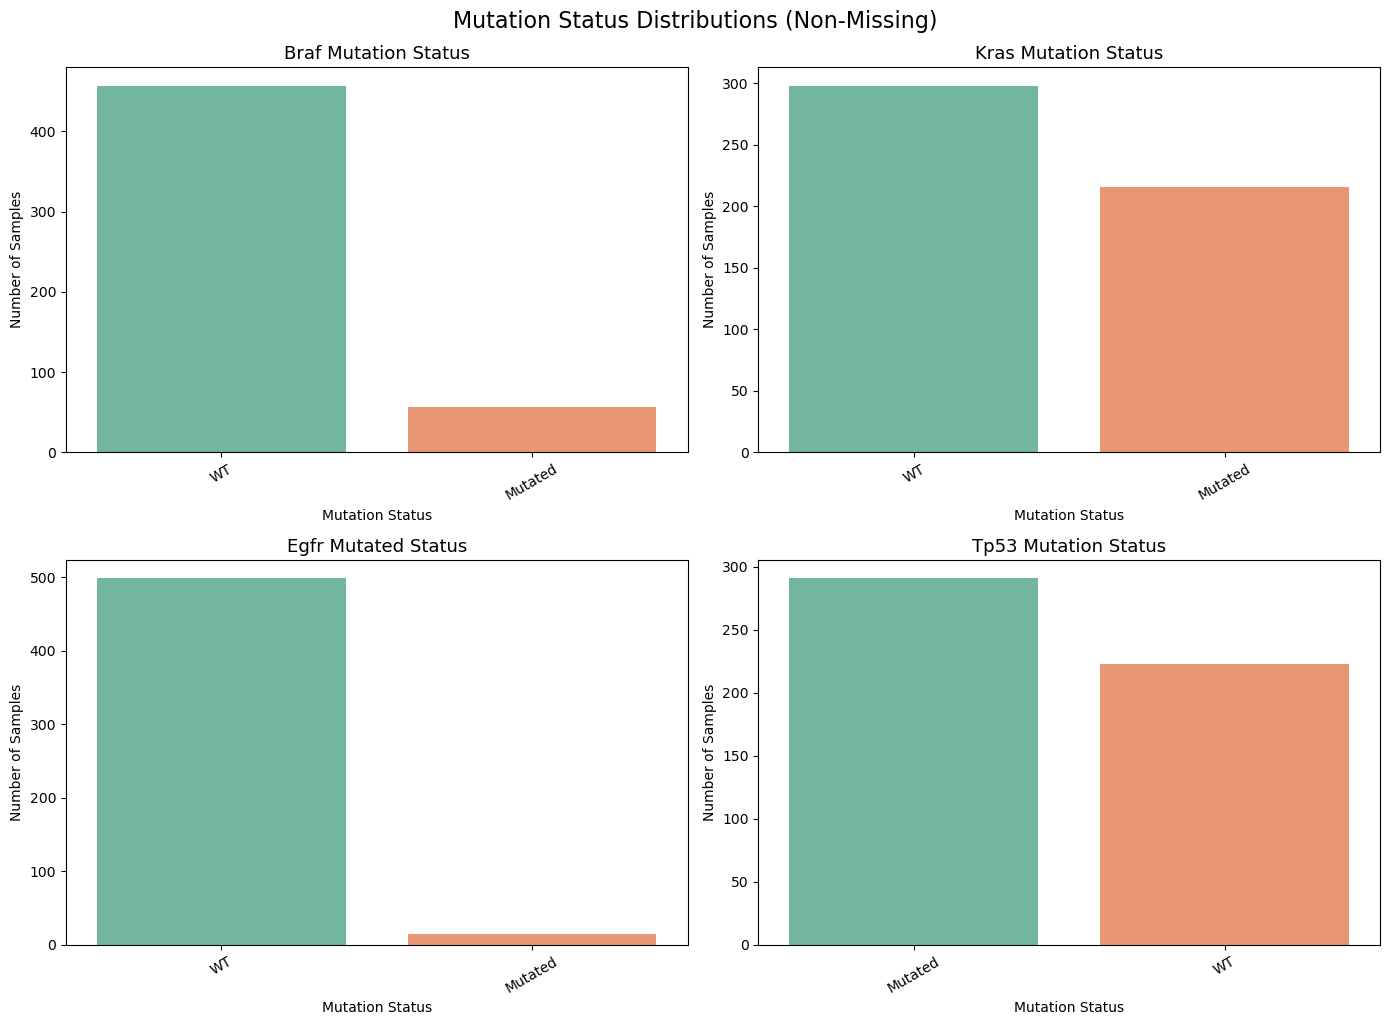

C:\Users\randf\AppData\Local\Temp\ipykernel_19728\1268288607.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_props.values * 100, y=missing_props.index, palette="Reds_r")


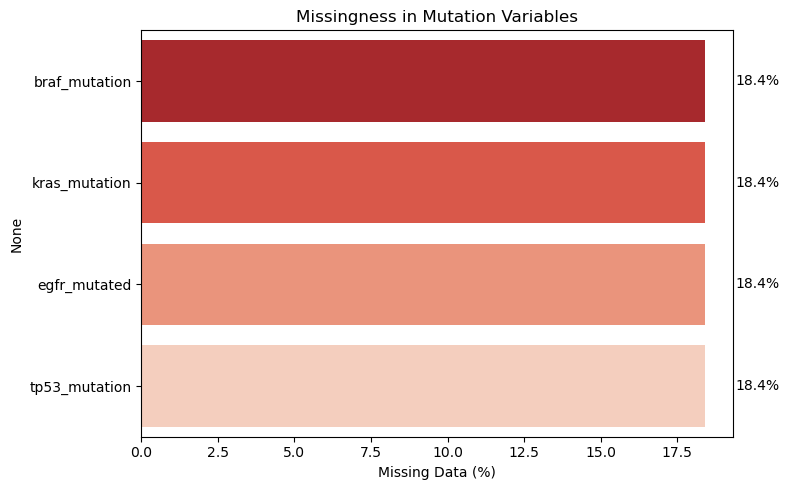

In [ ]:
# Mutation columns to explore
mutation_cols = ['braf_mutation', 'kras_mutation', 'egfr_mutated', 'tp53_mutation']

# 1. Plot mutation status distributions (excluding missing values)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, col in enumerate(mutation_cols):
    sns.countplot(data=cancer_df, x=col, ax=axs[i], palette='Set2')
    axs[i].set_title(f"{col.replace('_', ' ').title()} Status", fontsize=13)
    axs[i].set_ylabel("Number of Samples")
    axs[i].set_xlabel("Mutation Status")
    axs[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.suptitle("Mutation Status Distributions (Non-Missing)", fontsize=16, y=1.02)
plt.show()

# 2. Plot missing data percentages for mutation columns
missing_props = cancer_df[mutation_cols].isna().mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=missing_props.values * 100, y=missing_props.index, palette="Reds_r")
plt.xlabel("Missing Data (%)")
plt.title("Missingness in Mutation Variables")
for i, v in enumerate(missing_props.values):
    plt.text(v*100 + 1, i, f"{v:.1%}", va='center', fontsize=10)
plt.tight_layout()
plt.show()


## 🧬 Tumor Characteristic Distributions (Non-Missing)

The figure shows the distributions of key tumor characteristics among colorectal cancer samples labeled as **Primary cancer**, excluding missing values:

- **Stage**: The majority of samples are in **stage III** and **stage II**, with fewer cases in stages IV and I.
- **Grade**: The distribution is limited and skewed due to significant missing data (see note below).
- **Histological Type**: Most samples fall under the categories **"Neoplasm"** and **"Adenomas and adenocarcinomas"**.
- **Histological Subtype**: Dominated by **"Adenocarcinoma"** and **"Malignant tumor"**, followed by a long tail of less frequent subtypes.



### 📌 Data Quality and Missingness

- **Grade** has **96% missing values** and contributes minimal usable information.  
  👉 **Action**: This variable will be **dropped** from further analysis.

- **Stage** has **~57% missing values**, which is considerable.  
  👉 **Action**:  Using only complete cases for exploratory plots.

- **Histological Type** and **Histological Subtype** have **no missing data** and are informative.  
  👉 **Action**: These variables will be **retained** and may be considered for stratification or inclusion in predictive models. Very low classes in count will be merged, this can be done based on domain knowledge, I will do it based on count only for simplicity





C:\Users\randf\AppData\Local\Temp\ipykernel_19728\4154220850.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\4154220850.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), ha='right')
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\4154220850.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\4154220850.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.countplot(
C:\Users\randf\AppData\Local\Temp\ipykernel

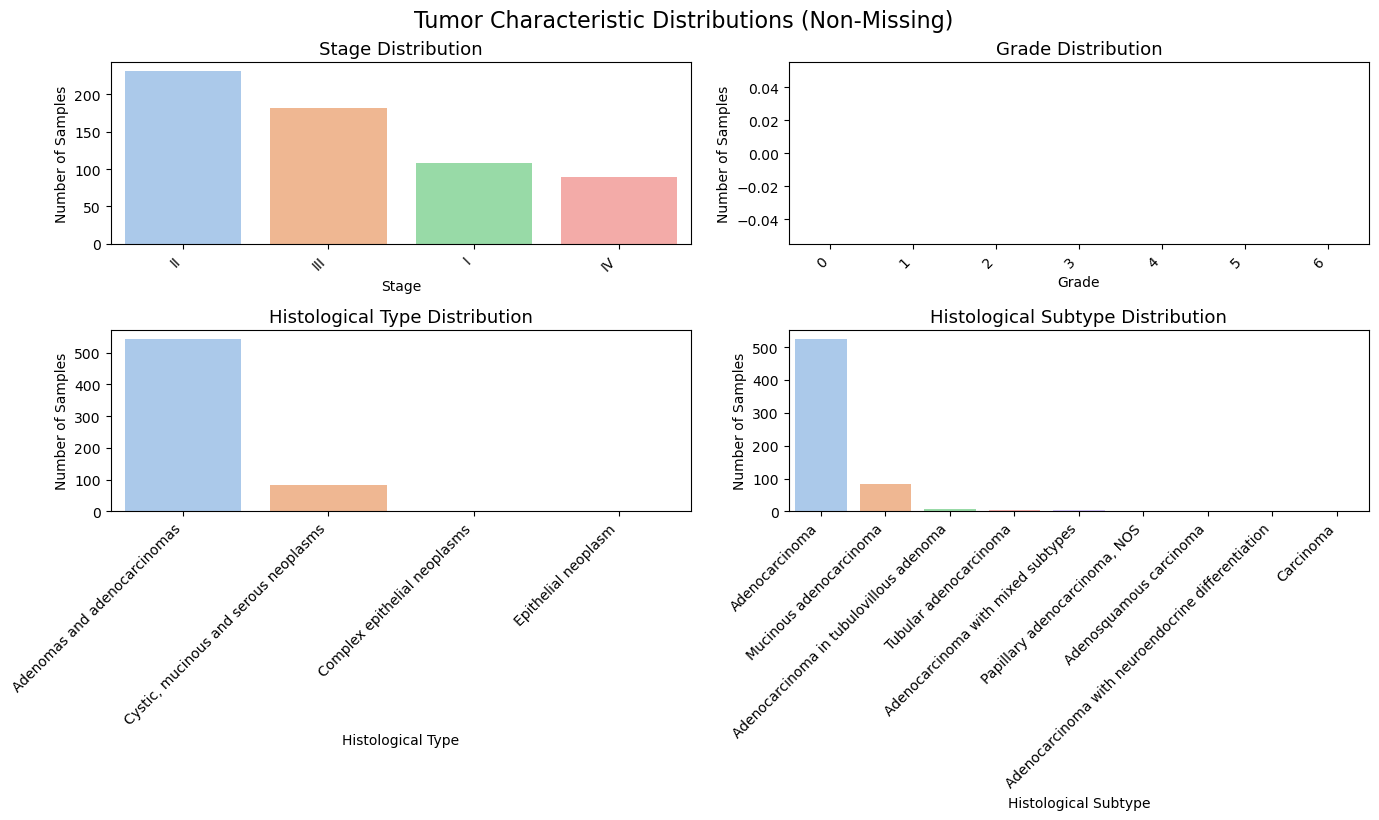

C:\Users\randf\AppData\Local\Temp\ipykernel_19728\4154220850.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_props.values * 100, y=missing_props.index, palette="Blues_r")


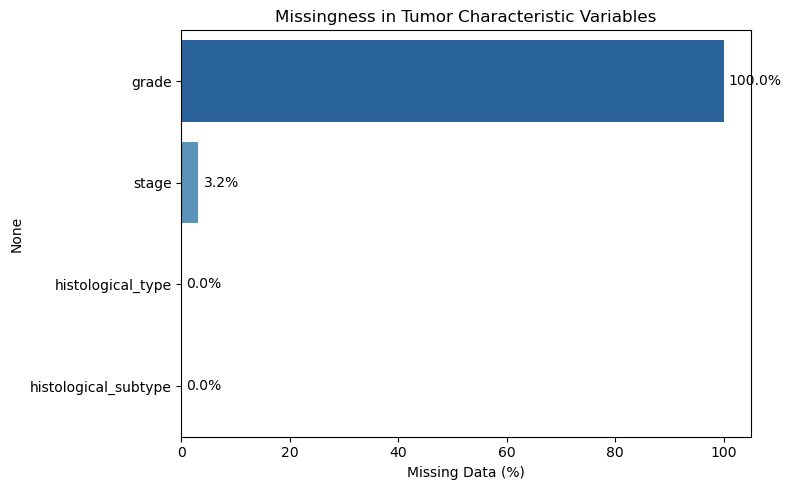

In [ ]:
# Tumor characteristic columns to explore
tumor_cols = ['stage', 'grade',  'histological_type', 'histological_subtype']

# 1. Plot tumor characteristic distributions (excluding missing values)
n_cols = 2
n_rows = -(-len(tumor_cols) // n_cols)  # Ceiling division for subplot grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axs = axs.flatten()

for i, col in enumerate(tumor_cols):
    sns.countplot(
        data=cancer_df,
        x=col,
        ax=axs[i],
        palette='pastel',
        order=cancer_df[col].dropna().value_counts().index  # Order by frequency
    )
    axs[i].set_title(f"{col.replace('_', ' ').title()} Distribution", fontsize=13)
    axs[i].set_ylabel("Number of Samples")
    axs[i].set_xlabel(col.replace('_', ' ').title())
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), ha='right')

# Remove unused axes if any
for j in range(len(tumor_cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle("Tumor Characteristic Distributions (Non-Missing)", fontsize=16, y=1.02)
plt.show()

# 2. Plot missing data percentages for tumor characteristic columns
missing_props = cancer_df[tumor_cols].isna().mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=missing_props.values * 100, y=missing_props.index, palette="Blues_r")
plt.xlabel("Missing Data (%)")
plt.title("Missingness in Tumor Characteristic Variables")
for i, v in enumerate(missing_props.values):
    plt.text(v*100 + 1, i, f"{v:.1%}", va='center', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# dropping grade
metadata_df = metadata_df.drop(['grade'], axis=1)

# Merge rare subtypes into 'Other'
subtype_counts = metadata_df['histological_subtype'].value_counts()
rare_subtypes = subtype_counts[subtype_counts < 100].index

metadata_df['histological_subtype'] = metadata_df['histological_subtype'].replace(rare_subtypes, 'Other')


# Merge rare types into 'Other'
subtype_counts = metadata_df['histological_type'].value_counts()
rare_subtypes = subtype_counts[subtype_counts < 100].index

metadata_df['histological_type'] = metadata_df['histological_type'].replace(rare_subtypes, 'Other')


C:\Users\randf\AppData\Local\Temp\ipykernel_19728\2734279038.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cancer_df, x=col, ax=axs[i], palette='Set3', order=cancer_df[col].dropna().value_counts().index)
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\2734279038.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), ha='right')
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\2734279038.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cancer_df, x=col, ax=axs[i], palette='Set3', order=cancer_df[col].dropna().value_counts().index)
C:\

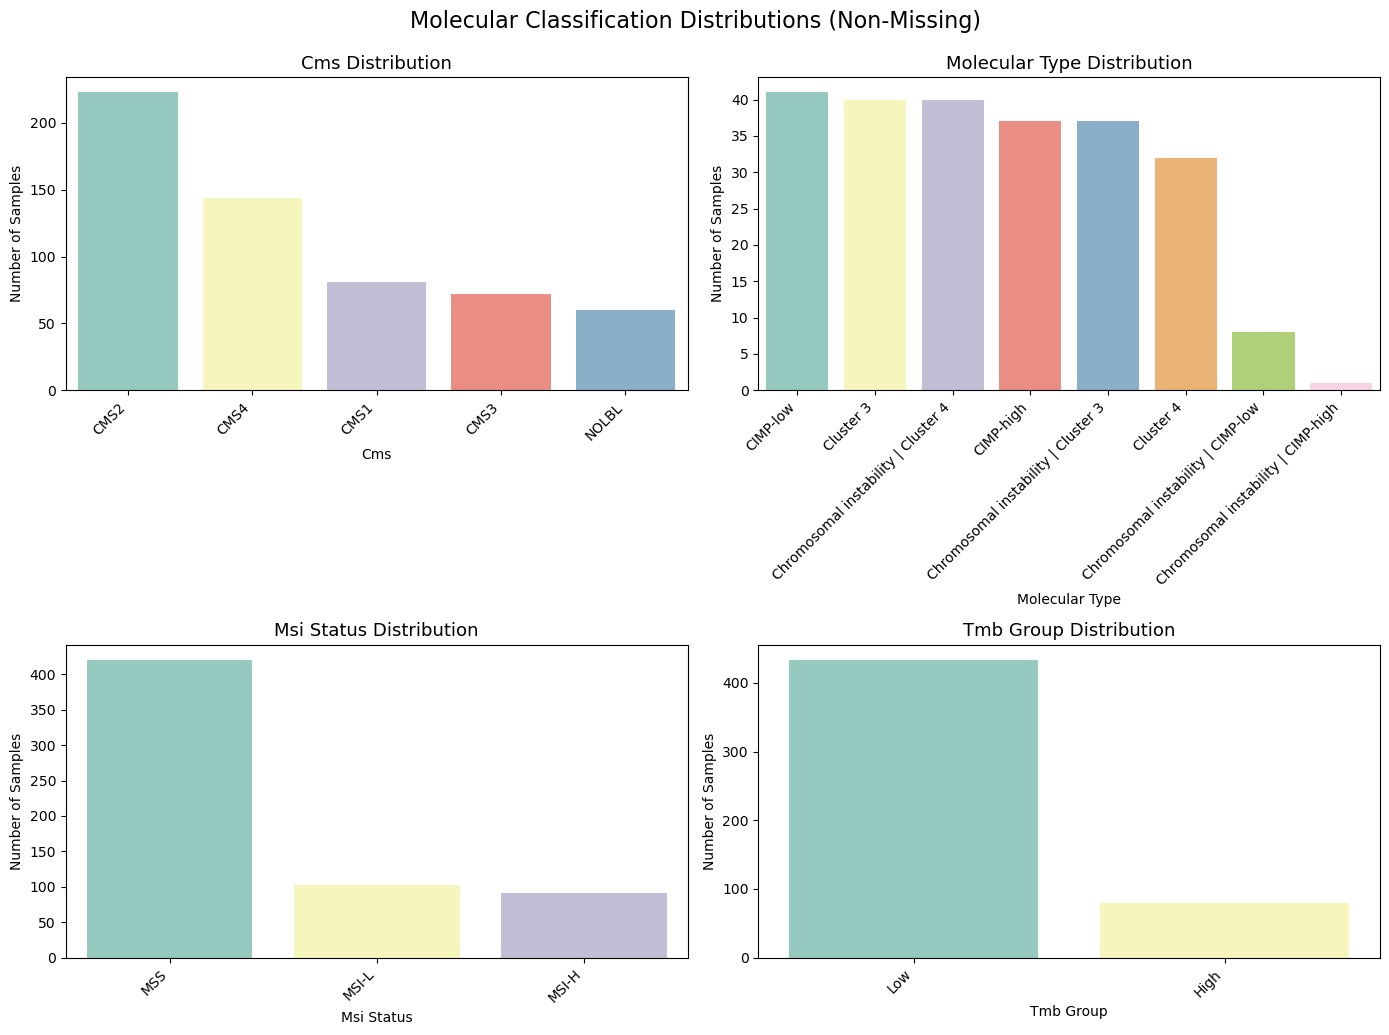

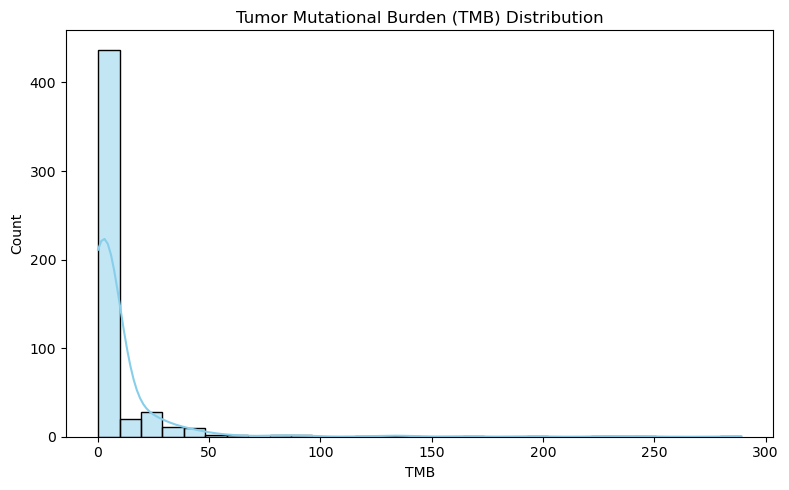

C:\Users\randf\AppData\Local\Temp\ipykernel_19728\2734279038.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_props.values * 100, y=missing_props.index, palette="Purples_r")


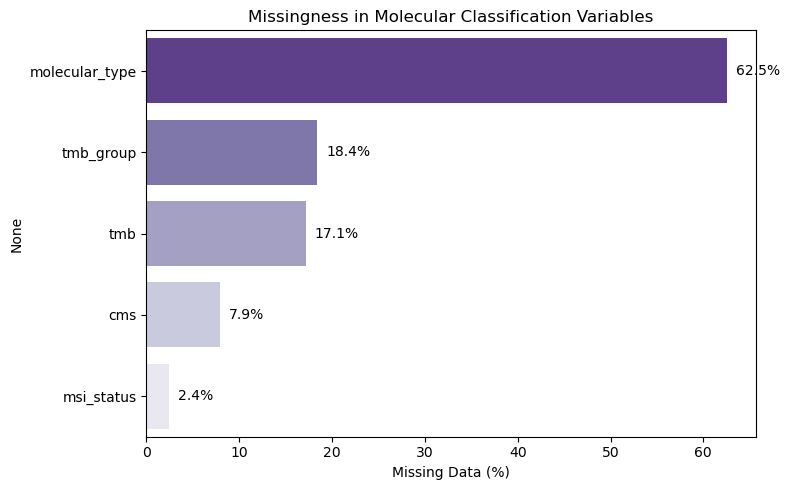

In [ ]:
# Molecular classification columns
molecular_categorical = ['cms', 'molecular_type', 'msi_status', 'tmb_group']
molecular_continuous = ['tmb']

# 1. Plot distributions of categorical molecular markers
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, col in enumerate(molecular_categorical):
    sns.countplot(data=cancer_df, x=col, ax=axs[i], palette='Set3', order=cancer_df[col].dropna().value_counts().index)
    axs[i].set_title(f"{col.replace('_', ' ').title()} Distribution", fontsize=13)
    axs[i].set_ylabel("Number of Samples")
    axs[i].set_xlabel(col.replace('_', ' ').title())
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), ha='right')

plt.tight_layout()
plt.suptitle("Molecular Classification Distributions (Non-Missing)", fontsize=16, y=1.03)
plt.show()

# 2. Plot distribution of TMB (continuous)
plt.figure(figsize=(8, 5))
sns.histplot(cancer_df['tmb'].dropna(), kde=True, bins=30, color='skyblue')
plt.title("Tumor Mutational Burden (TMB) Distribution")
plt.xlabel("TMB")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3. Missingness overview
mol_cols = molecular_categorical + molecular_continuous
missing_props = cancer_df[mol_cols].isna().mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=missing_props.values * 100, y=missing_props.index, palette="Purples_r")
plt.xlabel("Missing Data (%)")
plt.title("Missingness in Molecular Classification Variables")
for i, v in enumerate(missing_props.values):
    plt.text(v * 100 + 1, i, f"{v:.1%}", va='center', fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\randf\AppData\Local\Temp\ipykernel_19728\1955467821.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\1955467821.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), ha='right')
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\1955467821.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\randf\AppData\Local\Temp\ipykernel_19728\1955467821.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].

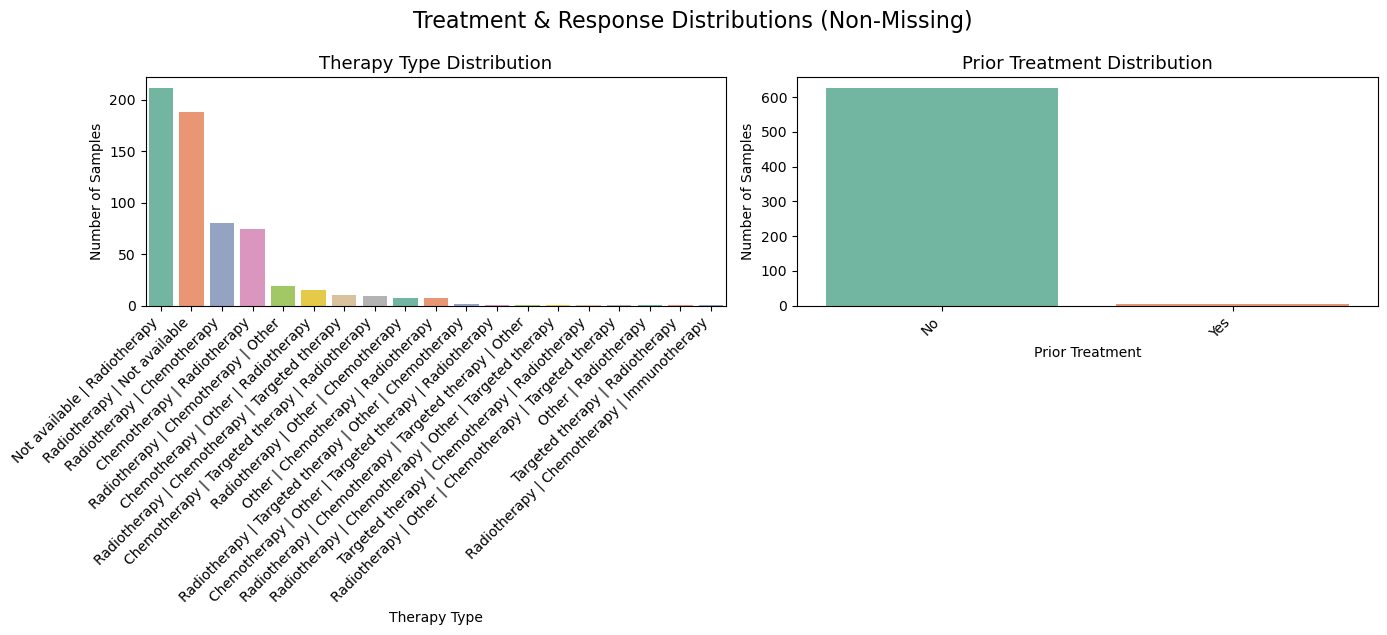

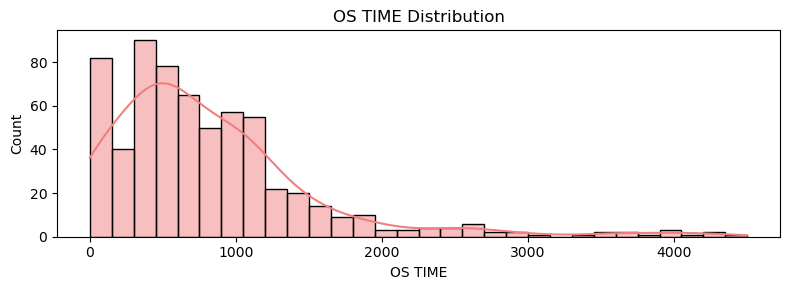

C:\Users\randf\AppData\Local\Temp\ipykernel_19728\1955467821.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


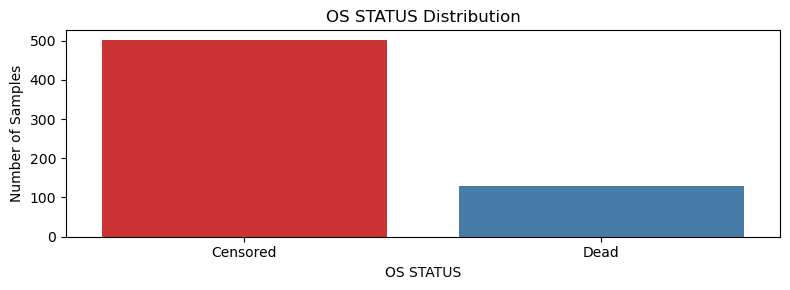

In [ ]:
# Define our new column groups
treatment_categorical = ['therapy_type', 'prior_treatment']
survival_continuous = ['os_time']
survival_categorical = ['os_status']  

# 1. Plot distributions of categorical treatment variables
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjust height for better aspect
axs = axs.flatten()

for i, col in enumerate(treatment_categorical):
    sns.countplot(
        data=cancer_df, 
        x=col, 
        ax=axs[i], 
        palette='Set2', 
        order=cancer_df[col].dropna().value_counts().index
    )
    axs[i].set_title(f"{col.replace('_', ' ').title()} Distribution", fontsize=13)
    axs[i].set_ylabel("Number of Samples")
    axs[i].set_xlabel(col.replace('_', ' ').title())
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), ha='right')

plt.tight_layout()
plt.suptitle("Treatment & Response Distributions (Non-Missing)", fontsize=16, y=1.05)
plt.show()


# 2. Plot distribution of survival continuous variables (os_time, pfs_time)
# Because only one variable, create a single subplot (no indexing needed)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for col in survival_continuous:
    sns.histplot(cancer_df[col].dropna(), kde=True, bins=30, color='lightcoral', ax=ax)
    ax.set_title(f"{col.replace('_', ' ').upper()} Distribution")
    ax.set_xlabel(col.replace('_', ' ').upper())
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


# 3. Plot distribution of survival status variables (categorical)
# Again, only one variable, so single axis, no indexing
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for col in survival_categorical:
    sns.countplot(
        data=cancer_df, 
        x=col, 
        palette='Set1', 
        order=cancer_df[col].dropna().value_counts().index,
        ax=ax
    )
    ax.set_title(f"{col.replace('_', ' ').upper()} Distribution")
    ax.set_xlabel(col.replace('_', ' ').upper())
    ax.set_ylabel("Number of Samples")
    ax.tick_params(axis='x', labelrotation=0)

plt.tight_layout()
plt.show()




C:\Users\randf\AppData\Local\Temp\ipykernel_19728\2424953805.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_props.values * 100, y=missing_props.index, palette="Blues_r")


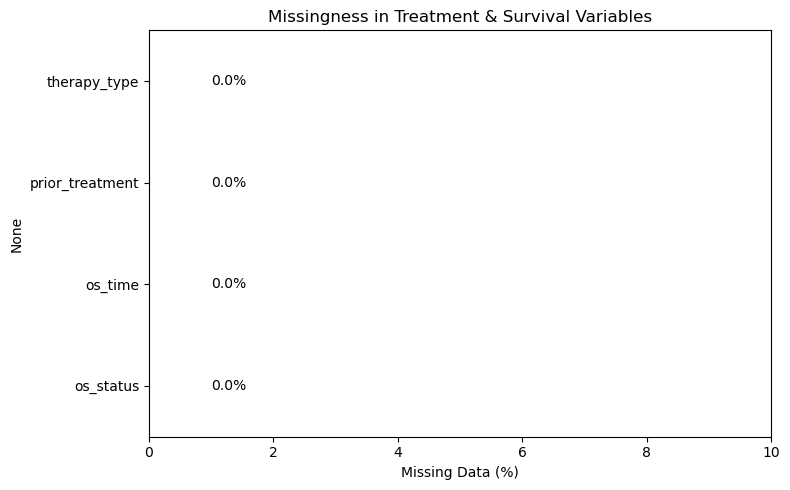

In [ ]:
# 4. Missingness overview for treatment and survival data
treat_surv_cols = treatment_categorical + survival_continuous + survival_categorical
missing_props = cancer_df[treat_surv_cols].isna().mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))  # Increase height for better spacing
sns.barplot(x=missing_props.values * 100, y=missing_props.index, palette="Blues_r")

plt.xlabel("Missing Data (%)")
plt.title("Missingness in Treatment & Survival Variables")

# Add text labels with a small offset on the right side of each bar
for i, v in enumerate(missing_props.values):
    plt.text(v * 100 + 1, i, f"{v:.1%}", va='center', fontsize=10)

plt.xlim(0, max(missing_props.values) * 100 + 10)  # Add some padding on x-axis
plt.tight_layout()
plt.show()


In [ ]:
# Create new columns based on therapy_type
def count_stages(s):
    if pd.isna(s) or s.strip() == '':
        return 1
    return s.count('|') + 1

def includes_therapy(s, therapy_name):
    if pd.isna(s):
        return 0
    return int(therapy_name.lower() in s.lower())

# Apply the functions
cancer_df['therapy_stages'] = cancer_df['therapy_type'].apply(count_stages)
cancer_df['has_radiotherapy'] = cancer_df['therapy_type'].apply(lambda x: includes_therapy(x, 'Radiotherapy'))
cancer_df['has_chemotherapy'] = cancer_df['therapy_type'].apply(lambda x: includes_therapy(x, 'Chemotherapy'))
cancer_df['has_targeted_therapy'] = cancer_df['therapy_type'].apply(lambda x: includes_therapy(x, 'Targeted therapy'))

# Drop the original 'therapy_type' column if needed
cancer_df = cancer_df.drop(columns=['therapy_type', 'tmb', 'molecular_type'])

c:\Users\randf\.conda\envs\crc_env\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


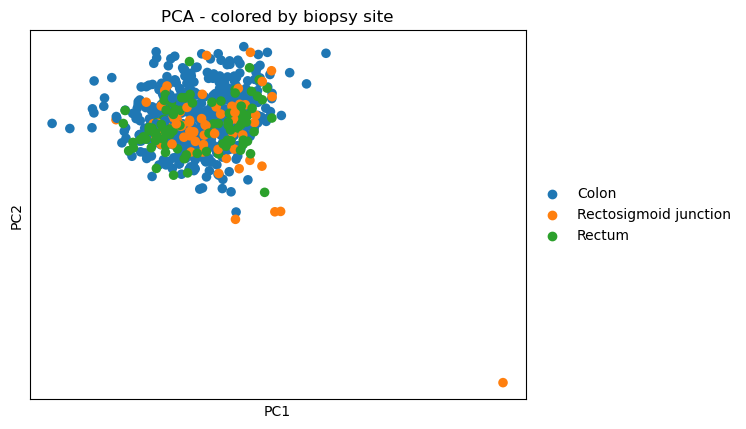

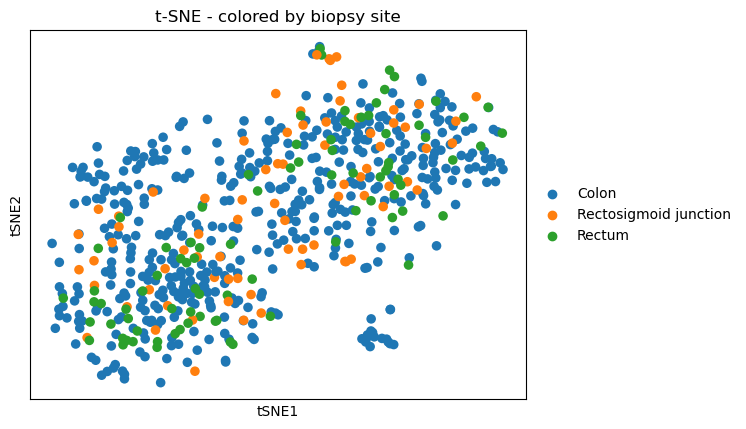

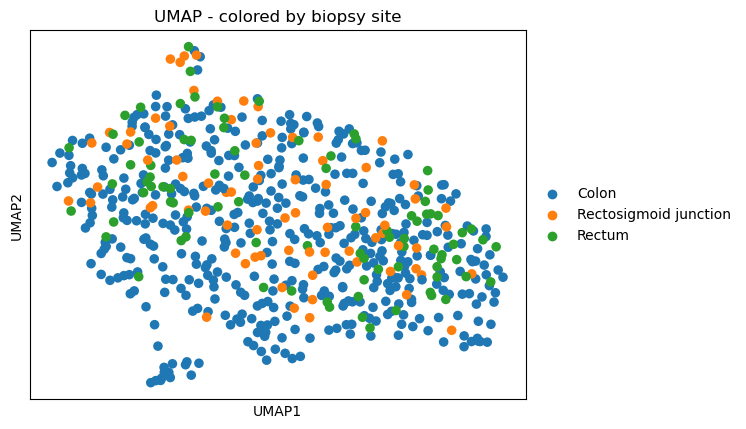

In [ ]:
# 2. Ensure the sample IDs match with AnnData object
# This filters expression data to tumor samples only
cancer_adata = anndata.AnnData(filtered_expr.loc[filtered_expr.index.intersection(cancer_df.index)])


# Add all columns from metadata_df to adata.obs
for col in cancer_df.columns:
    cancer_adata.obs[col] = cancer_df[col]

# Select Highly Variable Genes 
sc.pp.highly_variable_genes(cancer_adata, flavor='seurat', n_top_genes=400)
cancer_adata = cancer_adata[:, cancer_adata.var['highly_variable']]

# Scale data (z-score genes)
sc.pp.scale(cancer_adata)

# PCA
sc.tl.pca(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# Plot PCA colored by biopsy site
sc.pl.pca(cancer_adata, color='biopsy_site', title='PCA - colored by biopsy site')

# Plot t-SNE colored by biopsy site
sc.pl.tsne(cancer_adata, color='biopsy_site', title='t-SNE - colored by biopsy site')

# Plot UMAP colored by biopsy site
sc.pl.umap(cancer_adata, color='biopsy_site', title='UMAP - colored by biopsy site')

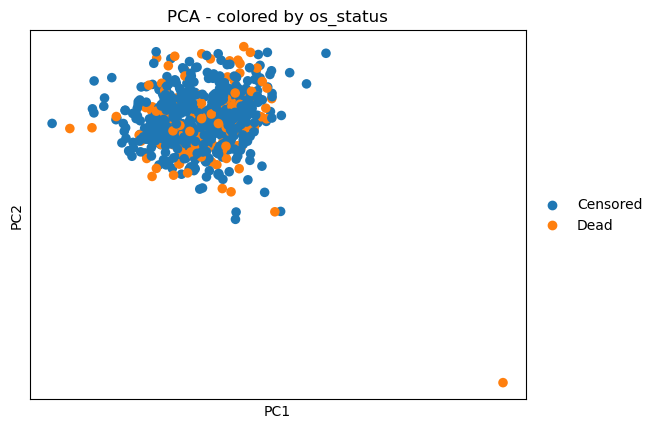

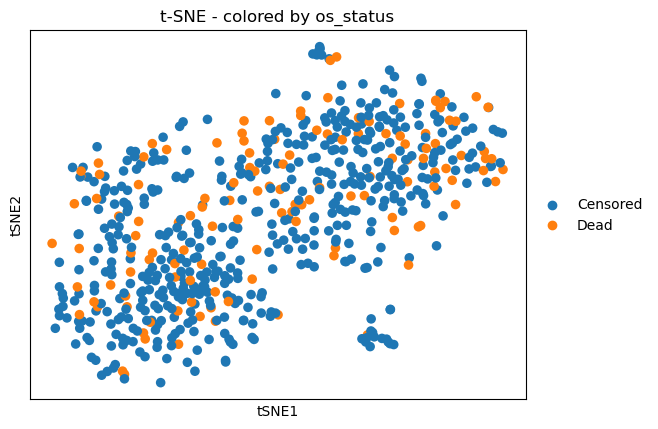

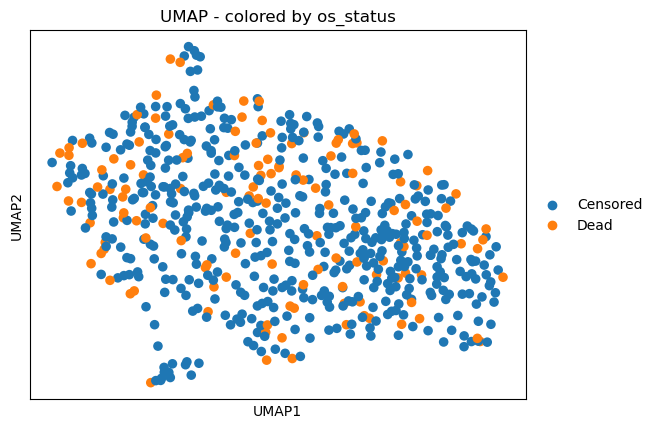

In [ ]:
# Plot PCA colored by biopsy site
sc.pl.pca(cancer_adata, color='os_status', title='PCA - colored by os_status')

# Plot t-SNE colored by biopsy site
sc.pl.tsne(cancer_adata, color='os_status', title='t-SNE - colored by os_status')

# Plot UMAP colored by biopsy site
sc.pl.umap(cancer_adata, color='os_status', title='UMAP - colored by os_status')

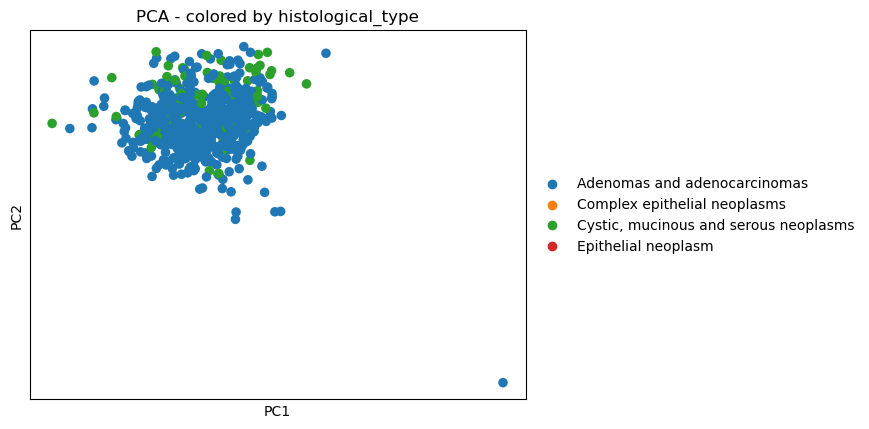

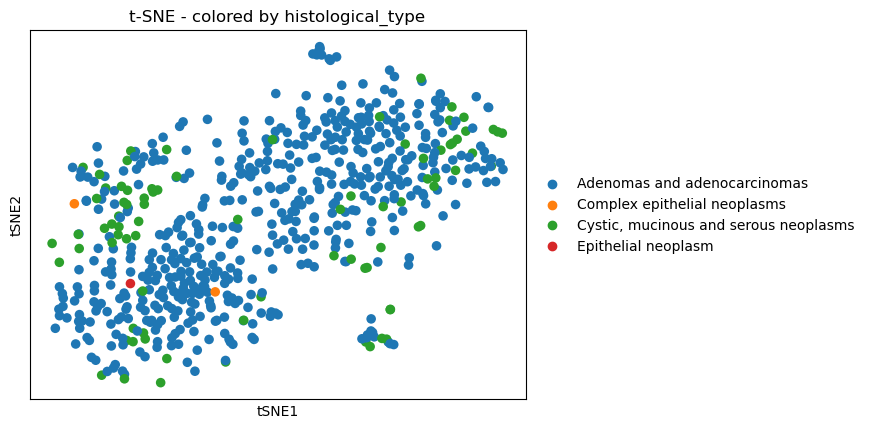

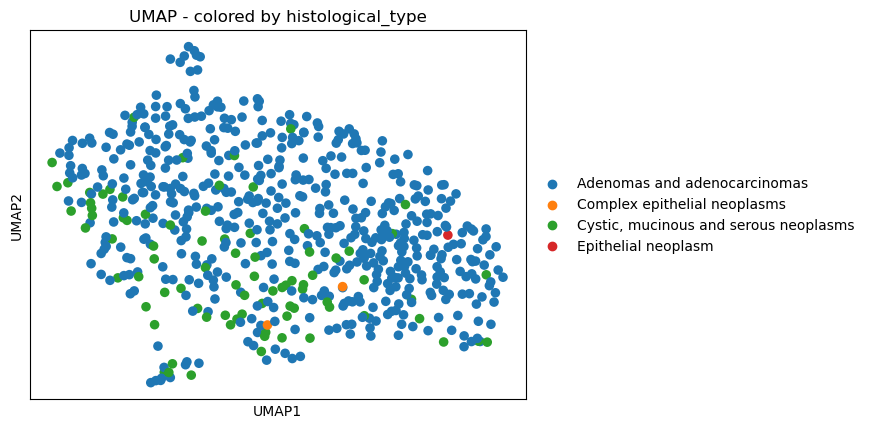

In [ ]:
# Plot PCA colored by biopsy site
sc.pl.pca(cancer_adata, color='histological_type', title='PCA - colored by histological_type')

# Plot t-SNE colored by biopsy site
sc.pl.tsne(cancer_adata, color='histological_type', title='t-SNE - colored by histological_type')

# Plot UMAP colored by biopsy site
sc.pl.umap(cancer_adata, color='histological_type', title='UMAP - colored by histological_type')

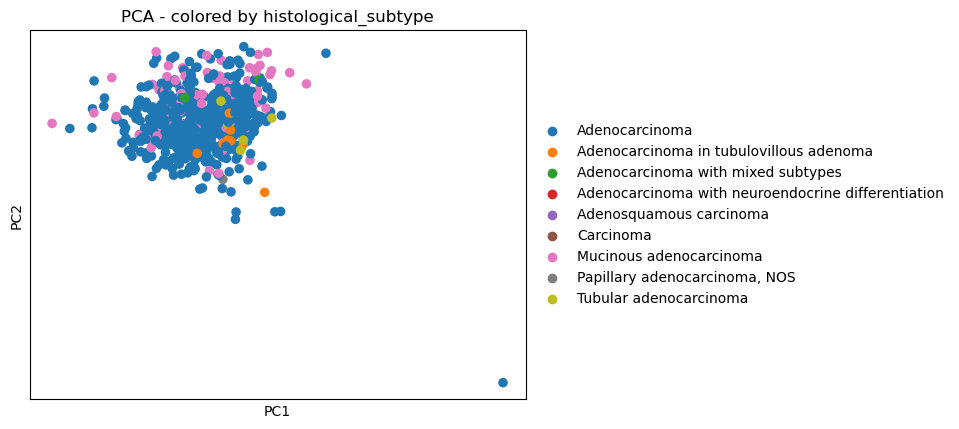

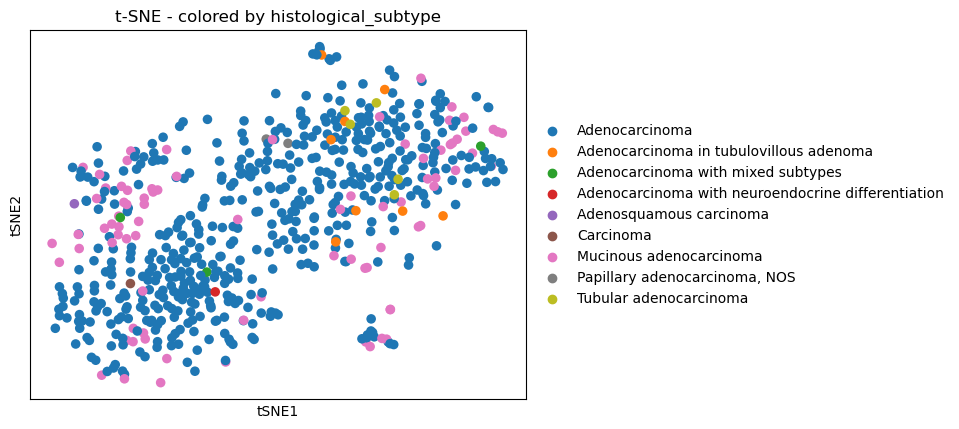

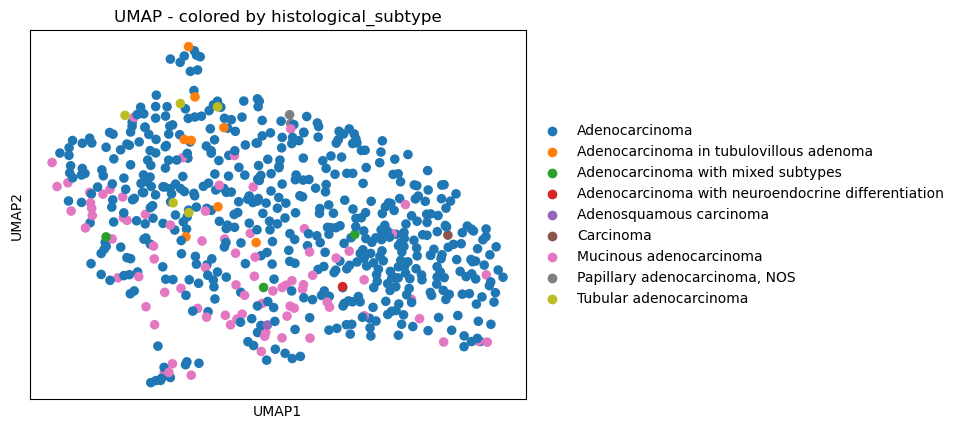

In [ ]:
# Plot PCA colored by biopsy site
sc.pl.pca(cancer_adata, color='histological_subtype', title='PCA - colored by histological_subtype')

# Plot t-SNE colored by biopsy site
sc.pl.tsne(cancer_adata, color='histological_subtype', title='t-SNE - colored by histological_subtype')

# Plot UMAP colored by biopsy site
sc.pl.umap(cancer_adata, color='histological_subtype', title='UMAP - colored by histological_subtype')

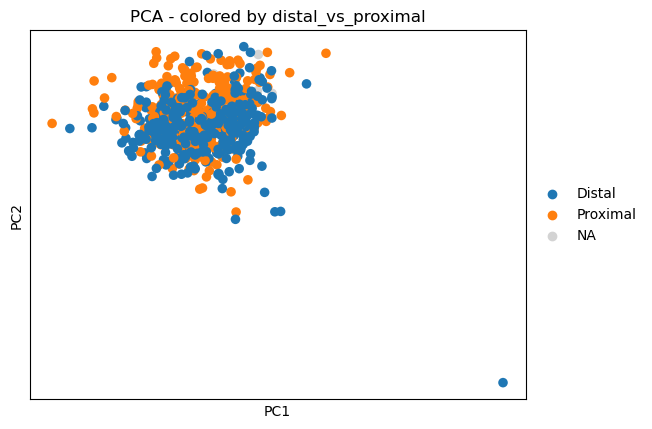

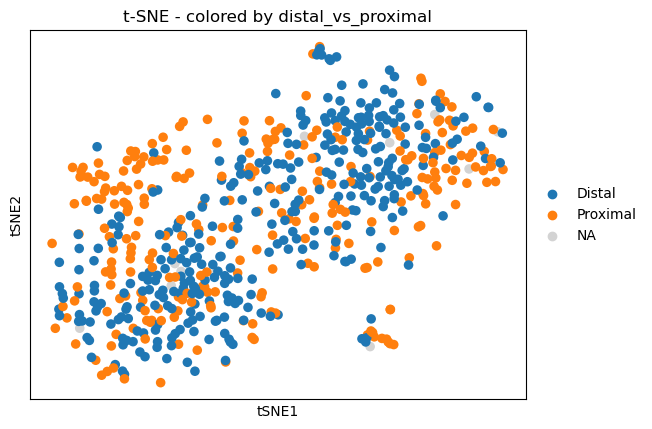

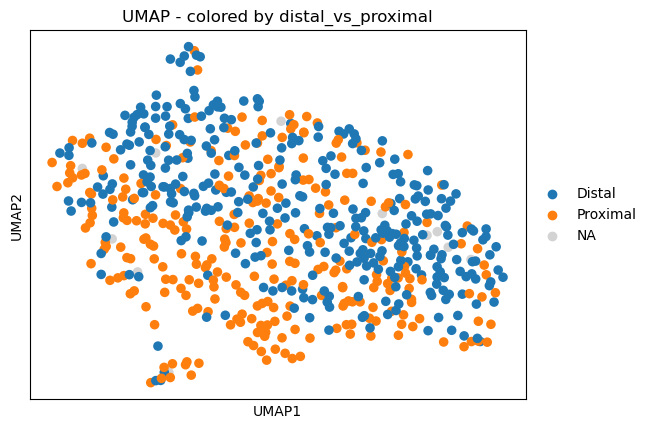

In [ ]:
# Plot PCA colored by biopsy site
sc.pl.pca(cancer_adata, color='distal_vs_proximal', title='PCA - colored by distal_vs_proximal')

# Plot t-SNE colored by biopsy site
sc.pl.tsne(cancer_adata, color='distal_vs_proximal', title='t-SNE - colored by distal_vs_proximal')

# Plot UMAP colored by biopsy site
sc.pl.umap(cancer_adata, color='distal_vs_proximal', title='UMAP - colored by distal_vs_proximal')